In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# TSNE a tool to visualize high-dimensional data
# It converts similarities between data points to joint probabilities
# tries to minimize KL divergence between joint probabilities of low-dimensional embedding and high-dimensional data
from sklearn.manifold import TSNE

# High-performance container datatypes 
import collections
import pandas as pd
import random
import math
import time

In [17]:
class Skipgram:
    def __init__(self,vocabulary_size=1500, batch_size = 128, embedding_size = 200, skip_window = 4,num_skips = 4,valid_size = 20,\
                valid_window = 500,num_sampled = 64,learning_rate=0.001,training_epochs = 200001,display_step=2000):
        self.vocabulary_size=vocabulary_size
        self.batch_size = batch_size 
        self.embedding_size = embedding_size 
        self.skip_window = skip_window 
        self.num_skips = num_skips 

        #self.batches_per_epoch = int(len(data)*self.num_skips/self.batch_size)

        self.valid_size = valid_size 
        self.valid_window = valid_window 
        self.valid_examples = np.random.choice(self.valid_window,self.valid_size,replace=False) 
        self.num_sampled = num_sampled

        self.learning_rate=learning_rate
        self.training_epochs = training_epochs 
        self.display_step=display_step
        self.data_index=0
        
    def gen_data(self,args):
        #args:filename
        df=pd.read_csv('sample.csv',names=['company','text'])
        tag_data=df['text'].dropna().values.tolist()
        tag_split=list(map(lambda x:x.split(),tag_data))
        self.words=[]
        for i in tag_split:
            self.words+=i

    def build_dataset(self):
        self.count = [["UNK",-1]]
        self.count.extend(collections.Counter(self.words).most_common(self.vocabulary_size - 1))
        self.dictionary = {}
        for word,_ in self.count:
            self.dictionary[word] = len(self.dictionary)
        self.data = []
        unk_count = 0 
        for word in self.words:
            if word in self.dictionary:
                index = self.dictionary[word]
            else:
                index = 0
                unk_count += 1
            self.data.append(index)
        self.count[0][1] = unk_count 
        self.reverse_dictionary = dict(zip(self.dictionary.values(),self.dictionary.keys()))
    
    def generate_batch(self,batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        span = 2 * skip_window + 1 # [ skip_window target skip_window ]
        buffer = collections.deque(maxlen=span)
        for _ in range(span):
            buffer.append(self.data[self.data_index])
            self.data_index = (self.data_index + 1) % len(self.data)
        for i in range(batch_size // num_skips):
            target = skip_window  # target label at the center of the buffer
            targets_to_avoid = [ skip_window ]
            for j in range(num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.append(self.data[self.data_index])
            self.data_index = (self.data_index + 1) % len(self.data)
        return batch, labels
    
    def build_model(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.train_inputs = tf.placeholder(tf.int32,[self.batch_size])
            self.train_labels = tf.placeholder(tf.int32,[self.batch_size,1])
            self.valid_dataset = tf.constant(self.valid_examples,tf.int32)

            with tf.device("/cpu:0"):
                embeddings = tf.Variable(tf.random_uniform([self.vocabulary_size,self.embedding_size],-1.0,1.0))
                embed = tf.nn.embedding_lookup(embeddings,self.train_inputs)
                nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size,self.embedding_size],stddev= 1.0 /math.sqrt(self.embedding_size)))
                nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))

                self.loss = tf.reduce_mean(tf.nn.nce_loss(
                    weights=nce_weights,
                    biases=nce_biases,
                    labels =self.train_labels,
                    inputs=embed,
                    num_sampled=self.num_sampled,
                    num_classes=self.vocabulary_size
                ))

                self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
                norm = tf.sqrt(tf.reduce_sum(tf.square(nce_weights),1,keep_dims=True))
                self.normalized_embeddings = nce_weights / norm 

                self.valid_embeddings = tf.nn.embedding_lookup(self.normalized_embeddings,self.valid_dataset) 
                self.similarity = tf.matmul(self.valid_embeddings,self.normalized_embeddings,transpose_b=True)
                self.init = tf.global_variables_initializer() 
    
    def train_model(self):
        with tf.Session(graph=self.graph) as session:
            self.init.run() 
            average_loss = 0 
            for epoch in range(self.training_epochs):
                batch_inputs,batch_labels = self.generate_batch(self.batch_size,self.num_skips,self.skip_window) 
                feed_dict = {self.train_inputs:batch_inputs,self.train_labels:batch_labels} 
                optimizer_trained,loss_val = session.run([self.optimizer,self.loss],feed_dict=feed_dict)
                average_loss += loss_val #sum NCE loss

                if epoch % self.display_step == 0:
                    if epoch > 0:
                        average_loss /= self.display_step
                    print("Average loss at epoch ", epoch, ":", average_loss)
                    average_loss = 0
                #print the top_match of validation words to see whether they fit our intuition
#                if epoch % 10000 == 0:
#                    sim = similarity.eval() 
#                    for i in range(valid_size):
#                        valid_word = reverse_dictionary[valid_examples[i]] 
#                        top_k = 8
#                        nearest = (-sim[i,:]).argsort()[1:top_k+1] 
#                        log_str = "Nearest neighbor of {}： ".format(str(valid_word))

#                        for k in range(top_k):
#                            close_word = reverse_dictionary[nearest[k]] 
#                            log_str = "%s %s, " %(log_str,close_word)
#                        print(log_str)
            self.final_embeddings = self.normalized_embeddings.eval()
    
    def plot_with_labels(self,low_dim_embs,labels,filename = "tsne.png"):
        assert low_dim_embs.shape[0] >= len(labels),"label number over embedding number！"

        plt.figure(figsize=(20,20))
        for i,label in enumerate(labels):
            x,y = low_dim_embs[i,:]
            plt.scatter(x,y)
            plt.annotate(
                label,
                xy = (x,y),
                xytext=(5,2),
                textcoords="offset points",
                ha="right",
                va="bottom"
            )
        plt.savefig(filename)
    def plot_tsne(self):
        tsne = TSNE(perplexity=30,n_components=2,init="pca",n_iter=5000)
        plot_only = 100
        low_dim_embs = tsne.fit_transform(self.final_embeddings[:plot_only,:])
        Labels = [self.reverse_dictionary[i] for i in range(plot_only)]
        self.plot_with_labels(low_dim_embs,Labels)
    
    def save_embedding(self):
        f = open('./skipgram_wordvec.txt', 'w+',encoding="utf-8")
        for index, item in enumerate(model.final_embeddings):
                f.write(model.reverse_dictionary[index]  + ' ' +' '.join([str(vec) for vec in item]) + '\n')
        f.close()

In [18]:
model=Skipgram()

model.gen_data('sample.csv')

model.build_dataset()

In [19]:
model.build_model()

In [20]:
model.train_model()

Average loss at epoch  0 : 172.74533081054688
Average loss at epoch  2000 : 52.5811885201931
Average loss at epoch  4000 : 8.958269863843919
Average loss at epoch  6000 : 5.661169700860977
Average loss at epoch  8000 : 4.808270164728165
Average loss at epoch  10000 : 4.620727431178093
Average loss at epoch  12000 : 4.645682335615158
Average loss at epoch  14000 : 4.524926634430885
Average loss at epoch  16000 : 4.575793397426605
Average loss at epoch  18000 : 4.469119294524193
Average loss at epoch  20000 : 4.551382844924927
Average loss at epoch  22000 : 4.411502401351929
Average loss at epoch  24000 : 4.54608544421196
Average loss at epoch  26000 : 4.375984412193298
Average loss at epoch  28000 : 4.548964543223381
Average loss at epoch  30000 : 4.365061221241951
Average loss at epoch  32000 : 4.502049903869629
Average loss at epoch  34000 : 4.434634044170379
Average loss at epoch  36000 : 4.405703315615654
Average loss at epoch  38000 : 4.4534275592565535
Average loss at epoch  40000

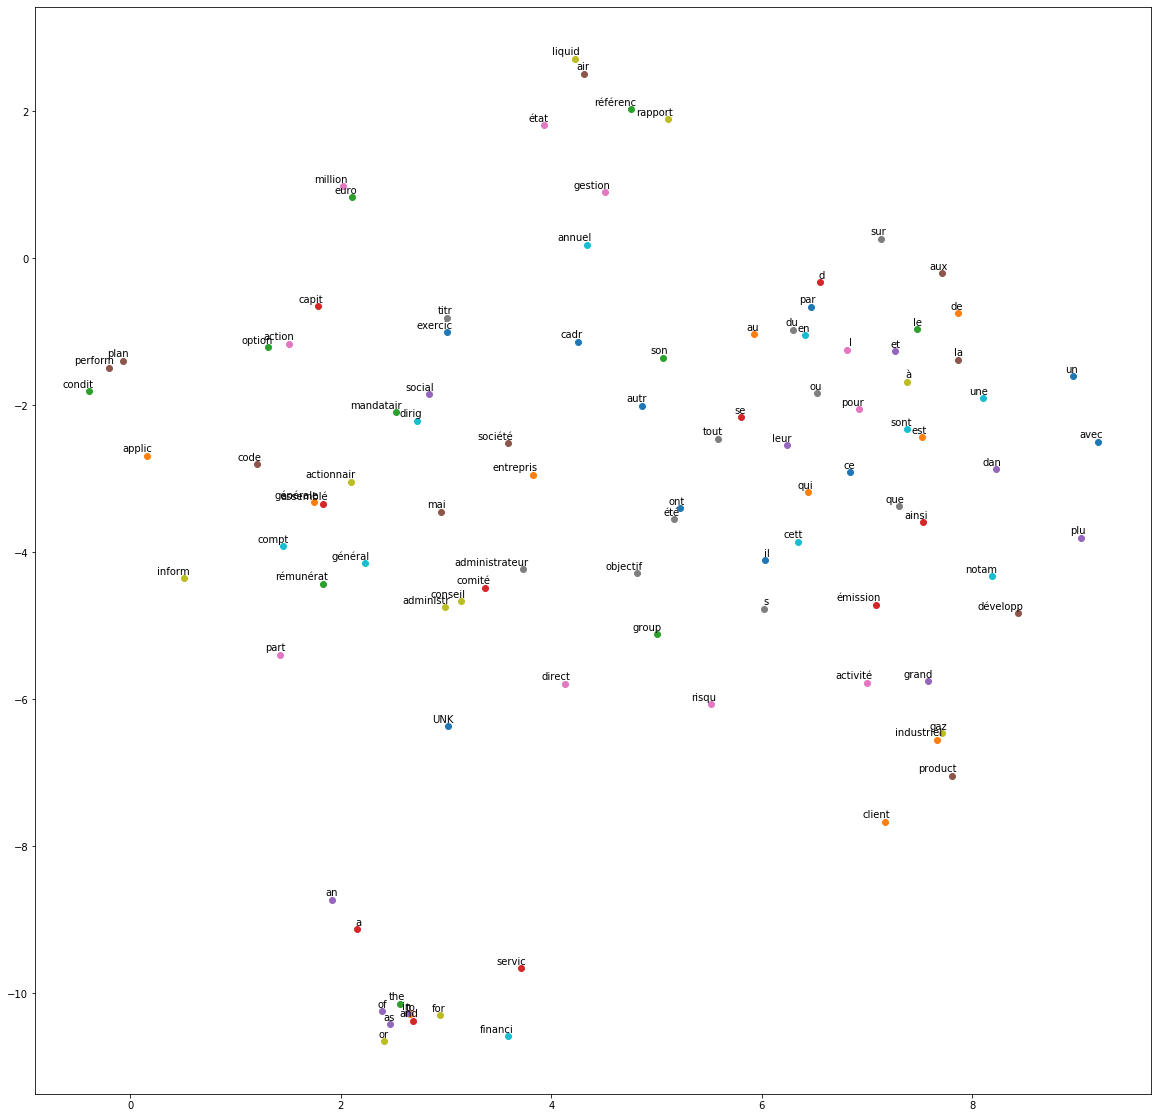

In [21]:
model.plot_tsne()

In [ ]:
model.save_embedding()